# Recogida de basuras por RL

Código principal para generar la simulación, añadir la red neuronal y el método de entrenamiento.

In [1]:
import math
import os
import sys
import time
import random

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import torch
import networkx as nx 
import osmnx as ox

Carga del grafo

In [2]:
# Obtenemos el grafo con los nodos de los contenedores de basura ya incluidos

G = ox.load_graphml("contenedores_resto_FCC_valencia_filtrado_grafo.graphml", node_dtypes={"osmid": str})
nodos, aristas = ox.graph_to_gdfs(G)

# Limitamos el rango de recogida de basuras al barrio de Benimàmet, València

nodos_zona = nodos[(-0.411672 > nodos["x"]) & (nodos["x"] > -0.431842) & (39.506424 > nodos["y"]) & (nodos["y"] > 39.495904)]
nodos_zona.to_csv("nodos_zona.csv", index=True, encoding="utf-8")

nodos_id = set(nodos_zona.index)
aristas_zona = aristas[aristas.index.get_level_values("u").isin(nodos_id) & aristas.index.get_level_values("v").isin(nodos_id)].copy()
aristas_zona.to_csv("aristas_zona.csv", index=True, encoding="utf-8")



In [3]:
# Separació Benimàmet en dos zonas (para entrenamiento)
norte = True
norte_reducido = True
sud = False

if norte: 
    nodos_preparacion = nodos_zona[(-0.416603 > nodos["x"]) & (nodos["x"] > -0.431842) & (39.506424 > nodos["y"]) & (nodos["y"] > 39.498466)]
    nodos_preparacion = nodos_preparacion[(-0.423650 > nodos["x"]) | (39.500643 < nodos["y"])]
    nodos_preparacion = nodos_preparacion[(-0.422801 > nodos["x"]) | (39.501206 < nodos["y"])]
    nodos_preparacion = nodos_preparacion[(-0.421208 > nodos["x"]) | (39.501935 < nodos["y"])]
    
    
    if norte_reducido: 
        nodos_preparacion = nodos_preparacion[(-0.427142 < nodos["x"]) & (39.500458 < nodos["y"])]
        nodos_preparacion = nodos_preparacion[-0.419560 > nodos["x"]]
        nodos_preparacion = nodos_preparacion[39.504647 > nodos["y"]]
        nodos_preparacion = nodos_preparacion[-0.419560 > nodos["x"]]
        nodos_preparacion = nodos_preparacion[-0.422650 > nodos["x"]]
        nodos_preparacion = nodos_preparacion[(-0.422902 > nodos["x"]) | (39.503329 > nodos["y"])]
    
    nodos_zona = nodos_preparacion
    nodos_id = set(nodos_zona.index)
    aristas_zona = aristas[aristas.index.get_level_values("u").isin(nodos_id) & aristas.index.get_level_values("v").isin(nodos_id)].copy()

if sud:
    nodos_zona
    aristas_zona    

nodos_en_grafo = (nodos_zona["x"]).count() 
contenedores_en_grafo = (nodos_zona["contenedor"]).count()
aristas_en_grafo = (aristas_zona["osmid"]).count() 
dist_media = (aristas_zona["length"]).mean() 
tiempo_medio = (aristas_zona["travel_time"]).mean() 
dist_desv = (aristas_zona["length"]).std() 
tiempo_desv = (aristas_zona["travel_time"]).std() 
dist_max = (aristas_zona["length"]).max() 
tiempo_max = (aristas_zona["travel_time"]).max() 
dist_min = (aristas_zona["length"]).min() 
tiempo_min = (aristas_zona["travel_time"]).min() 

print(f"Nodos en grafo: {nodos_en_grafo}")
print(f"Contenedores en grafo: {contenedores_en_grafo}")
print(f"Aristas en grafo: {aristas_en_grafo}")
print(dist_media, tiempo_medio)
print(dist_desv, tiempo_desv)
print(dist_max, tiempo_max)
print(dist_min, tiempo_min)

Nodos en grafo: 43
Contenedores en grafo: 11
Aristas en grafo: 63
56.31182360681151 6.384002146739517
32.219507884097496 3.6526859605038418
165.63561828926896 18.77790621945538
2.430573276270196 0.27555110134347904


c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\geopandas\geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\geopandas\geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\geopandas\geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\geopandas\geodataframe.py:1896: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\geopandas\geodataframe.p

Preparación tuplas de nodos_zona y aristas_zona del entorno

In [4]:
# Se trabaja con diccionarios

def generacion_dicc_nodos(nodos_zona):
    nodos_dicc = {}
    for indice, fila in nodos_zona.iterrows():
        nodos_dicc[indice] = {
            "indice" : indice,
            "contenedor" : 1 if fila["contenedor"] == "True" else 0,  # 1 sí,  0 no
            "capacidad_contenedor" : 2 if fila["contenedor"] == "True" else 0, # 1 unidad de llenado sí, 0 unidades de llenado no
            "llenado" :  0.7 if fila["contenedor"] == "True" else 0,  # 0.5 (50%) (valor inicial aleatorio) sí,  0 (0%) no
            "posicion_camion" : 0,                                    # 1 sí,  0 no
            "llenado_camion" : 0                                      # Dato compartido en todos los nodos, normalizado a 1   
        }

    return nodos_dicc

def generacion_dicc_aristas(aristas_zona):
    aristas_dicc = {}
    for indice, fila in aristas_zona.iterrows():
        aristas_dicc[indice] = {
            "indice" : fila["osmid"], 
            "desde" : indice[0],
            "hasta" : indice[1],
            "distancia" : fila["length"],  # m
            "tiempo_recorrido" : fila["travel_time"], # s
            "velocidad_media" : fila["speed_kph"], # Km/h (velocidad indicada por graphml)
            "velocidad_max" : 30, # Km/h (Consideración inicial vias interubanas) 
            "via" : fila["highway"]
        }

    return aristas_dicc


nodos_dicc = generacion_dicc_nodos(nodos_zona)
aristas_dicc = generacion_dicc_aristas(aristas_zona)


Modificación indices de los nodos para trabajar despues con las GNN (se almacena la relación para mostrar resultados)

In [5]:
def modificacion_indices(nodos_dicc, aristas_dicc):
    
    nodos_dicc_str = {str(k): v for k, v in nodos_dicc.items()}

    mapeo = {osmid: idx for idx, osmid in enumerate(nodos_dicc_str.keys())}
    mapeo_inverso = {idx: osmid for osmid, idx in mapeo.items()}

    nodos_dicc_ind = {}
    for osmid, data in nodos_dicc_str.items():
        new_idx = mapeo[osmid]
        nodo_copy = data.copy()
        nodo_copy["indice"] = new_idx
        nodos_dicc_ind[new_idx] = nodo_copy

    aristas_dicc_ind = {}
    for osmid, data in aristas_dicc.items():
        u_idx = mapeo[str(data["desde"])]
        v_idx = mapeo[str(data["hasta"])]
        arista_copy = data.copy()
        arista_copy["desde"] = u_idx
        arista_copy["hasta"] = v_idx
        aristas_dicc_ind[osmid] = arista_copy

    return nodos_dicc_ind, aristas_dicc_ind, mapeo, mapeo_inverso

nodos_indice, aristas_indice, mapeo, mapeo_inverso = modificacion_indices(nodos_dicc, aristas_dicc)
print(mapeo["120296151"])
print(mapeo_inverso[20])
print(nodos_indice)
print(aristas_indice)

0
344066201
{0: {'indice': 0, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 1: {'indice': 1, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 2: {'indice': 2, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 3: {'indice': 3, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 4: {'indice': 4, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 5: {'indice': 5, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 6: {'indice': 6, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 7: {'indice': 7, 'contenedor': 0, 'capacidad_contenedor': 0, 'llenado': 0, 'posicion_camion': 0, 'llenado_camion': 0}, 8: {'indice': 8, 'contenedor': 0, '

Preparación y entremaniento agente

In [6]:
from env_basuras_final import RecogidaBasurasEnv

# Asegúrate de tener estos dicts ya definidos en la sesión:
# nodos_indice, aristas_indice

env = RecogidaBasurasEnv(nodos_indice, aristas_indice, mascara = True, seed = 22)



Función evaluación modelo

In [7]:
import numpy as np
import pandas as pd

def _get_base_env(env):
    """
    Devuelve el entorno base (tu RecogidaBasurasEnv), desenrollando:
    VecNormalize -> (Dummy/Subproc)VecEnv -> Monitor -> env.
    """
    e = env
    # VecNormalize
    if hasattr(e, "venv"):
        e = e.venv
    # Dummy/SubprocVecEnv
    if hasattr(e, "envs"):
        e = e.envs[0]
    # Monitor / TimeLimit / etc.
    while hasattr(e, "env"):
        e = e.env
    # Gymnasium suele tener .unwrapped
    return getattr(e, "unwrapped", e)

def _is_vec_env(env) -> bool:
    return hasattr(env, "num_envs") or hasattr(env, "envs") or hasattr(env, "venv")

def eval_episode(env, model, deterministic: bool = True, max_steps: int = 175):
    """
    Ejecuta 1 episodio y devuelve:
      - df_episode con columnas:
        step, nodo_actual, contenedor, accion_tipo, accion_destino,
        accion_final, nodo_destino, reward, reward_acum
      - ep_rew (recompensa total)
      - steps (nº pasos)
    Soporta env normal (Monitor) y VecEnv/VecNormalize.
    """
    is_vec = _is_vec_env(env)

    # RESET
    if is_vec:
        obs = env.reset()         # batched
    else:
        obs, _ = env.reset()

    base = _get_base_env(env)
    nodo_origen = int(base.nodo_actual)
    contenedor  = int(base.nodos_indice[nodo_origen]["contenedor"])

    traj = []
    ep_rew, steps = 0.0, 0

    while steps < max_steps:
        # 1) Política
        act, _ = model.predict(obs, deterministic = deterministic)
        act = np.asarray(act)

        if is_vec:
            # Asegura forma (1,2) para MultiDiscrete([2, N])
            if act.ndim == 1:
                act = act[None, :]  # (1, 2)
            # Garantiza tipo entero
            act = act.astype(np.int64, copy=False)

            # 2) STEP batcheado
            obs, r, done, infos = env.step(act)

            # 3) Escalares para logging
            r_scalar   = float(np.asarray(r).reshape(-1)[0])
            done_scalar = bool(np.asarray(done).reshape(-1)[0])

            # 4) Lee estado actual del entorno base
            base = _get_base_env(env)
            nodo_destino = int(base.nodo_actual)
            carga_camion = int(base.carga_camion)

            # 5) Para registrar la acción explícita
            tipo, destino = int(act[0, 0]), int(act[0, 1])

        else:
            # Entorno no vectorizado: tupla simple
            act_flat = act.reshape(-1).astype(np.int64, copy=False)
            tipo, destino = int(act_flat[0]), int(act_flat[1])

            obs, r, term, trunc, _ = env.step((tipo, destino))
            r_scalar    = float(r)
            done_scalar = bool(term or trunc)

            base = _get_base_env(env)
            nodo_destino = int(base.nodo_actual)
            carga_camion = int(base.carga_camion)

        steps += 1
        ep_rew += r_scalar

        traj.append({
            "step": steps,
            "nodo_actual": nodo_origen,
            "contenedor": contenedor,
            "accion_tipo": tipo,                         # 0 mover, 1 recoger
            "accion_destino": destino,
            "accion_final": "recoger" if tipo == 1 else "mover",
            "nodo_destino": nodo_destino,
            "reward": r_scalar,
            "reward_acum": ep_rew,
            "carga_camion": carga_camion
        })

        if done_scalar:
            break

        # Siguiente iteración: actualiza origen y flag contenedor
        nodo_origen = nodo_destino
        contenedor  = int(base.nodos_indice[nodo_origen]["contenedor"])

    df_episode = pd.DataFrame(traj)
    print(f"[EVAL] determinista={deterministic} | recompensa={ep_rew:.2f} | steps={steps}")
    return df_episode, ep_rew, steps



# Entrenamiento A2C con paralelización

Ronda 22

In [8]:
# main.py
# ------------------------------------------------------------
# Lanza el entrenamiento con multiprocessing y guardado a CARPETAS.
# Asegúrate de definir/importar nodos_indice y aristas_indice ANTES.
# ------------------------------------------------------------
import os
from A2C_algoritmo import train_a2c, lr_lineal

# Aquí debes tener ya:
# from tu_modulo_grafo import nodos_indice, aristas_indice
# o haberlos construido arriba en este mismo archivo/notebook.

ronda = "24"

def main():
    cfg = dict(
        #total_timesteps = 9_000,
        total_timesteps = 12_000_000,
        n_envs = 6,             
        n_steps = 128,  
        learning_rate = lr_lineal(3e-4, 3e-5),
        ent_coef_inicial = 0.25,
        ent_coef_final = 0.005,
        gamma = 0.99,            # Discount Reward
        gae_lambda = 0.97,
        vf_coef = 0.7,
        max_grad_norm = 0.5,
        beta_int = 0,           # Intrínseco  (necesario con la explícita?)
        alpha = 0.995,            # Intrínseco
        seed = 56,
        device = "cuda",
        run_name = f"ronda_{ronda}",
        models_dir = "./models/a2c",
        tb_dir = "./logs/tb-a2c",
        #save_freq = 4_500,
        save_freq = 600_000,     # checkpoints cada 450k a carpeta
    )

    model, final_dir = train_a2c(
        nodos_indice = nodos_indice,
        aristas_indice = aristas_indice,
        **cfg
    )

    print("[FIN] Entrenamiento completado.")
    print("Carpeta final:", final_dir)

    return model


if __name__ == "__main__":
    model = main()

c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\torch_geometric\typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\Lib\site-packages\libpyg.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [

[INFO] VecEnv usado: SubprocVecEnv | n_envs=6
Using cuda device
Logging to ./logs/tb-a2c\ronda_24\csv


c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
c:\Users\jgilg\Desktop\Master_IA_VIU\TFM\codigo_github\rl_env\lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 75.2     |
|    ep_rew_mean        | -2.67    |
| time/                 |          |
|    fps                | 435      |
|    iterations         | 30       |
|    time_elapsed       | 52       |
|    total_timesteps    | 23040    |
| train/                |          |
|    ent_coef           | 0.25     |
|    entropy_loss       | -0.669   |
|    explained_variance | 0.196    |
|    learning_rate      | 0.000299 |
|    n_updates          | 29       |
|    policy_loss        | 0.0132   |
|    value_loss         | 0.68     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 38.3     |
|    ep_rew_mean        | -1.59    |
| time/                 |          |
|    fps                | 434      |
|    iterations         | 60       |
|    time_elapsed       | 105      |
|    total_timesteps    | 46080    |
|

In [9]:
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import os

# === 1) Fábrica de un env idéntico al de train ===
def make_eval_env():
    def _fn():
        return Monitor(
            RecogidaBasurasEnv(
                nodos_indice = nodos_indice,
                aristas_indice = aristas_indice,
                steps_maximo = 175,
                mascara = True,
                seed = 123,
            )
        )
    return _fn

# === 2) Crear VecEnv (vectorizado de 1) ===
eval_vec = DummyVecEnv([make_eval_env()])

# === 3) Cargar estadísticas de VecNormalize guardadas en training ===
VECNORM_PATH = f"./models/a2c/ronda_{ronda}/final/vecnormalize.pkl"   # ajusta la ruta a la tuya
if os.path.exists(VECNORM_PATH):
    eval_vec = VecNormalize.load(VECNORM_PATH, eval_vec)
else:
    raise FileNotFoundError(f"No se encontró {VECNORM_PATH}. Asegúrate de haber guardado VecNormalize al entrenar.")

# === 4) Modo evaluación (sin actualizar stats) y recompensas “reales” (desnormalizadas) ===
eval_vec.training = False
eval_vec.norm_reward = False   # pon True si quieres ver rewards normalizadas

# (opcional) asocia el env al modelo si lo cargaste sin env
# model.set_env(eval_vec)

# === 5) Evaluar con tu helper (ya soporta VecEnv) ===
for i in range(10):
    eval_episode(eval_vec, model, deterministic = True, max_steps = 175)
    

[EVAL] determinista=True | recompensa=-1.40 | steps=2
[EVAL] determinista=True | recompensa=-1.96 | steps=12
[EVAL] determinista=True | recompensa=-1.83 | steps=13
[EVAL] determinista=True | recompensa=-1.40 | steps=2
[EVAL] determinista=True | recompensa=-1.66 | steps=9
[EVAL] determinista=True | recompensa=-1.40 | steps=2
[EVAL] determinista=True | recompensa=-1.40 | steps=2
[EVAL] determinista=True | recompensa=-1.56 | steps=8
[EVAL] determinista=True | recompensa=-1.96 | steps=12
[EVAL] determinista=True | recompensa=-1.40 | steps=2


## Extra

Extracción pesos del modelo ya entrenado y guardado en carpeta

In [10]:
import os
import torch
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from env_basuras_final import RecogidaBasurasEnv
from sb3_policy_mascara import A2CPolicyGNNMasked

ronda_carga = "24"

def make_eval_env():
    # Env base idéntico al de training (misma seed/rangos/máscara, etc.)
    return Monitor(
        RecogidaBasurasEnv(
            nodos_indice = nodos_indice,
            aristas_indice = aristas_indice,
            steps_maximo = 175,
            mascara = True,
            seed = 123,
        )
    )

# 1) VecEnv “crudo”
raw_vec = DummyVecEnv([make_eval_env])

# 2) Intenta cargar estadísticas de normalización
folder = f"./models/a2c/ronda_{ronda_carga}/final"
vecnorm_path = os.path.join(folder, "vecnormalize.pkl")

if os.path.exists(vecnorm_path):
    eval_vec = VecNormalize.load(vecnorm_path, raw_vec)
    # Eval: no actualices estadísticas, y no normalices reward
    eval_vec.training = False
    eval_vec.norm_reward = False
    # Si entrenaste con norm_obs_keys, se restauran desde el pickle
else:
    print("[WARN] No se encontró vecnormalize.pkl; evaluando SIN normalización de observaciones.")
    eval_vec = raw_vec

# 3) Crea el modelo “vacío” con los mismos policy_kwargs
policy_kwargs = dict(
    hidden_dim = 256,
    in_node_features = 4,
    in_edge_features = 2,
    n_tipos = 2,
    max_nodes = len(nodos_indice),
    gnn_layers = 4,
)

model_fold = A2C(
    policy = A2CPolicyGNNMasked,
    env = eval_vec,                   # <- MUY IMPORTANTE: usar el env normalizado
    policy_kwargs = policy_kwargs,
    device = "cuda",
    verbose = 1,
)

# 4) Carga pesos
state_path = os.path.join(folder, "policy_state.pt")
opt_path   = os.path.join(folder, "optimizer_state.pt")

sd = torch.load(state_path, map_location=model_fold.policy.device)
model_fold.policy.load_state_dict(sd)

if os.path.exists(opt_path) and hasattr(model_fold.policy, "optimizer") and model_fold.policy.optimizer is not None:
    opt_sd = torch.load(opt_path, map_location=model_fold.policy.device)
    model_fold.policy.optimizer.load_state_dict(opt_sd)

print("Pesos cargados desde carpeta:", folder)

Using cuda device
Pesos cargados desde carpeta: ./models/a2c/ronda_24/final


In [11]:
for i in range(10):
    eval_episode(env, model_fold, deterministic = False, max_steps = 175)

[EVAL] determinista=False | recompensa=-5.92 | steps=175
[EVAL] determinista=False | recompensa=-1.40 | steps=2
[EVAL] determinista=False | recompensa=-1.40 | steps=2
[EVAL] determinista=False | recompensa=-1.76 | steps=10
[EVAL] determinista=False | recompensa=-4.61 | steps=175
[EVAL] determinista=False | recompensa=-1.40 | steps=2
[EVAL] determinista=False | recompensa=-1.40 | steps=2
[EVAL] determinista=False | recompensa=-5.05 | steps=161
[EVAL] determinista=False | recompensa=-2.70 | steps=147
[EVAL] determinista=False | recompensa=-1.40 | steps=2


In [12]:
import os
import folium
import pandas as pd
import numpy as np
from shapely.geometry import LineString

# ================== 1) Ejecutar episodio ==================
deterministico = False  # True -> determinista, False -> no determinista
df_episode, R, S = eval_episode(env, model_fold, deterministic = deterministico, max_steps = 175)
print(df_episode)

# ================== 2) GDFs / mapeos ==================
gdf_nodes = nodos_zona.copy()
gdf_edges = aristas_zona.copy()

# Asegura columnas u,v
if "u" not in gdf_edges.columns or "v" not in gdf_edges.columns:
    if isinstance(gdf_edges.index, pd.MultiIndex):
        gdf_edges = gdf_edges.reset_index()

# ================== 3) Serie de estados / visitas por nodo ==================
if not df_episode.empty:
    start_node_internal = int(df_episode.loc[0, "nodo_actual"])
    estados_internal = [start_node_internal] + df_episode["nodo_destino"].astype(int).tolist()
else:
    estados_internal = []

def map_internal(i):
    i = int(i)
    return mapeo_inverso[i] if i in mapeo_inverso else None

estados_orig = [map_internal(i) for i in estados_internal]
estados_orig = [nid for nid in estados_orig if nid in gdf_nodes.index]

visitas_counts = pd.Series(estados_orig, dtype="object").value_counts() if len(estados_orig) else pd.Series([], dtype="int64")
gdf_nodes["visitas"] = gdf_nodes.index.map(visitas_counts).fillna(0).astype(int)

# ================== 4) Recogidas por contenedor ==================
rows_pick = df_episode[df_episode["accion_tipo"] == 1].copy()
if not rows_pick.empty:
    rows_pick["node_id"] = rows_pick["nodo_actual"].map(map_internal)
    rows_pick = rows_pick[rows_pick["node_id"].isin(gdf_nodes.index)]
    pickups_counts = rows_pick["node_id"].value_counts()
else:
    pickups_counts = pd.Series([], dtype="int64")
gdf_nodes["pickups"] = gdf_nodes.index.map(pickups_counts).fillna(0).astype(int)

# ================== 5) Conteo dirigidos (u->v) ==================
moves = df_episode[(df_episode["accion_tipo"] == 0) & (df_episode["nodo_destino"] != df_episode["nodo_actual"])].copy()
if not moves.empty:
    moves["u"] = moves["nodo_actual"].map(map_internal)
    moves["v"] = moves["nodo_destino"].map(map_internal)
    moves = moves[moves["u"].isin(gdf_nodes.index) & moves["v"].isin(gdf_nodes.index)]
    edge_counts = moves.groupby(["u","v"]).size().to_dict()
else:
    edge_counts = {}

# Conjunto de aristas presentes para detectar bidireccionalidad
edges_set = set(zip(gdf_edges["u"], gdf_edges["v"]))

# ================== 6) Construir mapa ==================
if len(estados_orig) > 0:
    c0 = (float(gdf_nodes.loc[estados_orig[0], "y"]), float(gdf_nodes.loc[estados_orig[0], "x"]))
else:
    c0 = (39.4699, -0.3763)
m = folium.Map(location=[c0[0], c0[1]], zoom_start=15)

# ---- 6.a) Aristas: color fijo; grosor fijo; tooltip según direccionalidad; badges por dirección ----
WEIGHT_USED = 3
WEIGHT_UNUSED = 2

def interp_point(geom: LineString, t: float):
    try:
        p = geom.interpolate(t, normalized=True)
        return float(p.y), float(p.x)
    except Exception:
        rp = geom.representative_point()
        return float(rp.y), float(rp.x)

for _, erow in gdf_edges.iterrows():
    geom = erow.get("geometry")
    if geom is None:
        continue

    u = erow["u"]; v = erow["v"]
    cnt_uv = int(edge_counts.get((u, v), 0))
    cnt_vu = int(edge_counts.get((v, u), 0))
    has_reverse = (v, u) in edges_set  # ¿existe la fila inversa v->u?

    used = (cnt_uv > 0) or (cnt_vu > 0 if has_reverse else False)
    color = "#0000cc" if used else "#000000"
    weight = WEIGHT_USED if used else WEIGHT_UNUSED
    opacity = 0.9 if used else 0.5

    # Tooltip según direccionalidad
    if has_reverse:
        tooltip_txt = f"Arista {u} ↔ {v} · u→v: {cnt_uv} · v→u: {cnt_vu}"
    else:
        tooltip_txt = f"Arista {u} → {v} · pasadas: {cnt_uv}"

    # Dibujar línea
    if geom.geom_type == "LineString":
        coords = [(lat, lon) for lon, lat in geom.coords]
        folium.PolyLine(coords, color=color, weight=weight, opacity=opacity, tooltip=tooltip_txt).add_to(m)
    elif geom.geom_type == "MultiLineString":
        for part in geom:
            coords = [(lat, lon) for lon, lat in part.coords]
            folium.PolyLine(coords, color=color, weight=weight, opacity=opacity, tooltip=tooltip_txt).add_to(m)

    # Badges:
    #   - Siempre badge u→v si cnt_uv>0 en t=0.35
    #   - Badge v→u:
    #        * si NO existe fila (v,u), lo ponemos aquí en t=0.65
    #        * si SÍ existe fila (v,u), se pintará cuando toque esa fila (evitamos duplicado)
    if cnt_uv > 0:
        yx = interp_point(geom, 0.35)
        folium.Marker(
            [yx[0], yx[1]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    background:#0000cc; color:white; padding:1px 4px;
                    border-radius:10px; font-size:10px; border:1px solid #001a80;
                    box-shadow:0 0 2px rgba(0,0,0,0.3);">
                    {cnt_uv}
                </div>'''),
            tooltip=f"{u} → {v}: {cnt_uv} pasadas"
        ).add_to(m)

    if cnt_vu > 0 and not has_reverse:
        yx = interp_point(geom, 0.65)
        folium.Marker(
            [yx[0], yx[1]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    background:#0000cc; color:white; padding:1px 4px;
                    border-radius:10px; font-size:10px; border:1px solid #001a80;
                    box-shadow:0 0 2px rgba(0,0,0,0.3);">
                    {cnt_vu}
                </div>'''),
            tooltip=f"{v} → {u}: {cnt_vu} pasadas"
        ).add_to(m)

# ---- 6.b) Nodos: contenedores verdes (visitas + recogidas), otros grises (solo visitas) ----
for nid, nrow in gdf_nodes.iterrows():
    lat, lon = float(nrow["y"]), float(nrow["x"])
    visitas = int(nrow.get("visitas", 0))
    pickups = int(nrow.get("pickups", 0))
    visitas = visitas - pickups
    is_container = (nrow["contenedor"] == "True")

    if is_container:
        color = "#0b6623"     # verde
        tooltip = f"Contenedor {nid} · visitas: {visitas} · recogidas: {pickups}"
        radius = 5
    else:
        color = "#666666"     # gris
        tooltip = f"Nodo {nid} · visitas: {visitas}"
        radius = 5

    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        color=color, weight=1,
        fill=True, fill_color=color, fill_opacity=0.9,
        tooltip=tooltip
    ).add_to(m)

# ================== 7) Guardar ==================
base_dir = f"./test/A2C/ronda_{ronda_carga}"
base_dir_no_det = base_dir + "/no_deterministico"
os.makedirs(base_dir, exist_ok=True)
os.makedirs(base_dir_no_det, exist_ok=True)

if deterministico:
    html_path = os.path.join(base_dir, f"mapa_ruta_contenedores_ronda_{ronda_carga}_det.html")
    csv_path  = os.path.join(base_dir, f"df_episode_ronda_{ronda_carga}_det.csv")
else:
    html_path = os.path.join(base_dir_no_det, f"mapa_ruta_contenedores_ronda_{ronda_carga}_no_det.html")
    csv_path  = os.path.join(base_dir_no_det, f"df_episode_ronda_{ronda_carga}_no_det.csv")

m.save(html_path)
df_episode.to_csv(csv_path, index=True)
print(f"[OK] Mapa guardado en: {html_path}")
print(f"[OK] df_episode guardado en: {csv_path}")



[EVAL] determinista=False | recompensa=-2.31 | steps=175
     step  nodo_actual  contenedor  accion_tipo  accion_destino accion_final  \
0       1            0           0            0               5        mover   
1       2            5           0            0               1        mover   
2       3            1           0            0               1        mover   
3       4            1           0            0               2        mover   
4       5            2           0            0               3        mover   
..    ...          ...         ...          ...             ...          ...   
170   171           41           1            0              19        mover   
171   172           19           0            0              20        mover   
172   173           20           0            0              40        mover   
173   174           40           1            1              40      recoger   
174   175           40           1            1              40

C:\Users\jgilg\AppData\Local\Temp\ipykernel_72792\2418141871.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["reward_acum"] = pd.to_numeric(df["reward_acum"], errors="coerce").fillna(method="ffill")


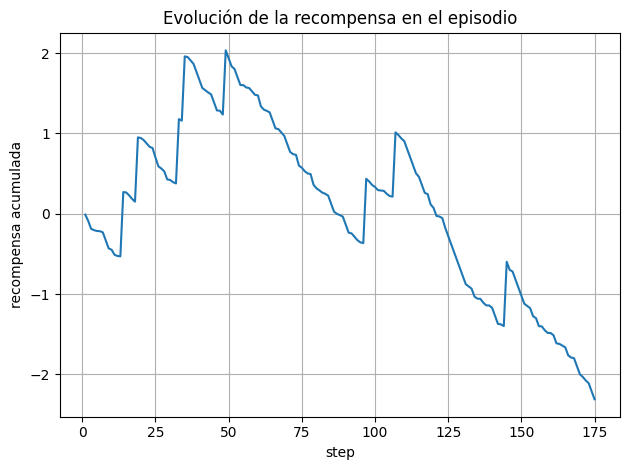

Ejecucion acción recogida total: 20
Nodos con contenedor recogidos total: 20
Nodos sin contenedor recogidos total: 0 

Contenedores recogidos con basura (> umbral): 8
Contenedores recogidos sin basura (< umbral): 12
Cantidad total recogida: 8.0 


Ejecución acción mover: 155
Ejecución acción mover real: 116
Ejecución acción quedarse: 39 

Nodos que han ejecutado acción mover: 41
Nodos que han ejecutado acción mover real: 41
Nodos que han ejecutado acción quedarse: 9 


Recompensa por recoger total: 5.200000000000002
Recompensa por recoger contenedores: 5.200000000000002
Recompensa por recoger no contenedores: 0.0
Recompensa por recoger contenedores validos/llenos: 6.4
Recompensa por recoger contenedores no validos/vacios: -1.2000000000000002 

Recompensa por mover total: -7.509730178664947
Recompensa por mover real: -3.609730178664945
Recompensa por quedarse quieto: -3.900000000000001 

Recompensa total episodio: -2.309730178664945


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df_episode.copy().sort_values("step")
df["step"] = pd.to_numeric(df["step"], errors="coerce").astype(int)

df["reward_acum"] = pd.to_numeric(df["reward_acum"], errors="coerce").fillna(method="ffill")

plt.figure()
plt.plot(df["step"], df["reward_acum"], linewidth=1.5)
plt.grid(True)
plt.xlabel("step")
plt.ylabel("recompensa acumulada")
plt.title("Evolución de la recompensa en el episodio")
plt.tight_layout()
plt.show()

mascara_recogida = df["accion_tipo"] == 1
total_ejecucion_recogida = int(mascara_recogida.sum())

mascara_recogida_contenedores = (df["accion_tipo"] == 1) & (df["contenedor"] == 1)
nodos_recogidos_con = set(df.loc[mascara_recogida_contenedores, "nodo_actual"].astype(int))
total_contenedores_con = len(nodos_recogidos_con)               # primeras veces (únicos)
total_contenedores = int(mascara_recogida_contenedores.sum())                     # todos los intentos
ejecucion_recogida_no_contenedor = total_ejecucion_recogida - total_contenedores
total_contenedores_sin = total_contenedores - total_contenedores_con

total_cantidad_recogida = float(df["carga_camion"].iloc[-1])

print(f"Ejecucion acción recogida total: {total_ejecucion_recogida}")
print(f"Nodos con contenedor recogidos total: {total_contenedores}")
print(f"Nodos sin contenedor recogidos total: {ejecucion_recogida_no_contenedor} \n")
print(f"Contenedores recogidos con basura (> umbral): {total_contenedores_con}")
print(f"Contenedores recogidos sin basura (< umbral): {total_contenedores_sin}")

print(f"Cantidad total recogida: {total_cantidad_recogida} \n\n")

mascara_mover = df["accion_tipo"] == 0
mascara_mover_quieto = (df["nodo_actual"] == df["nodo_destino"]) & (df["accion_tipo"] == 0)
mascara_mover_real = (df["nodo_actual"] != df["nodo_destino"]) & (df["accion_tipo"] == 0)
conteo_mover = int(mascara_mover.sum())
conteo_mover_nodos = int(df.loc[mascara_mover, "nodo_actual"].nunique())
conteo_mover_real = int(mascara_mover_real.sum())
conteo_mover_real_nodos = int(df.loc[mascara_mover_real, "nodo_actual"].nunique())
conteo_quedarse = int(mascara_mover_quieto.sum())
conteo_quedarse_nodos = int(df.loc[mascara_mover_quieto, "nodo_actual"].nunique())
quedarse_por_nodo = df.loc[mascara_mover_quieto, "nodo_actual"].value_counts()

print(f"Ejecución acción mover: {conteo_mover}")
print(f"Ejecución acción mover real: {conteo_mover_real}")
print(f"Ejecución acción quedarse: {conteo_quedarse} \n")
print(f"Nodos que han ejecutado acción mover: {conteo_mover_nodos}")
print(f"Nodos que han ejecutado acción mover real: {conteo_mover_real_nodos}")
print(f"Nodos que han ejecutado acción quedarse: {conteo_quedarse_nodos} \n\n")


recompensa_recoger = df["reward"][mascara_recogida].sum()
recompensa_recoger_cont = df["reward"][mascara_recogida_contenedores].sum()
mascara_recogida_no_cont = (df["accion_tipo"] == 1) & (df["contenedor"] == 0)
recompensa_recoger_no_cont = df["reward"][mascara_recogida_no_cont].sum()
mascara_recoger_cont_val = (df["accion_tipo"] == 1) & (df["reward"] > 0) 
recompnesa_recoger_cont_val = df["reward"][mascara_recoger_cont_val].sum()
mascara_recoger_cont_no_val = (df["accion_tipo"] == 1) & (df["reward"] < 0) 
recompensa_recoger_cont_no_val = df["reward"][mascara_recoger_cont_no_val].sum()

recompensa_mover_total = df["reward"][mascara_mover].sum()
recompensa_mover_quieto = df["reward"][mascara_mover_quieto].sum()
recompensa_mover_real = df["reward"][mascara_mover_real].sum()

print(f"Recompensa por recoger total: {recompensa_recoger}")
print(f"Recompensa por recoger contenedores: {recompensa_recoger_cont}")
print(f"Recompensa por recoger no contenedores: {recompensa_recoger_no_cont}")
print(f"Recompensa por recoger contenedores validos/llenos: {recompnesa_recoger_cont_val}")
print(f"Recompensa por recoger contenedores no validos/vacios: {recompensa_recoger_cont_no_val} \n")

print(f"Recompensa por mover total: {recompensa_mover_total}")
print(f"Recompensa por mover real: {recompensa_mover_real}")
print(f"Recompensa por quedarse quieto: {recompensa_mover_quieto} \n")

recompensa_final = df["reward"].sum()
print(f"Recompensa total episodio: {recompensa_final}")









In [14]:
from analisis_mascara import analizar_mascaras

res = analizar_mascaras(eval_vec, pasos=10000, seed=123)


=== Diagnóstico de máscaras ===
estados_total                     : 10000
estados_con_0_acciones            : 0
pct_con_0_acciones                :   0.00%
estados_deterministas_(1_accion)  : 0
pct_deterministas                 :   0.00%
joint_acciones_validas_media      : 2.0
joint_acciones_validas_p50        : 2.0
joint_acciones_validas_p90        : 2.0
joint_acciones_validas_p99        : 2.0
tipos_validos_media               : 1.2201
destinos_validos_tipo0_media      : 1.7799
destinos_validos_tipo1_media      : 1.0

Histograma de nº de acciones conjuntas válidas (top 10):
     2  -> 10000 estados (100.00%)
